In [3]:
import numpy as np
from pytomography.io.SPECT import simind
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib.colors import LinearSegmentedColormap
import torch
from pytomography.transforms import SPECTAttenuationTransform, SPECTPSFTransform
from pytomography.projectors import SPECTSystemMatrix
from pytomography.algorithms import OSEM, FilteredBackProjection
from scipy.ndimage import rotate
colors = np.loadtxt('pet_colors.txt').reshape(-1,3)/255.0
custom_cmap = LinearSegmentedColormap.from_list('custom_colormap', colors)

The command 

* `simind jaszak test/fi:lu177/CC:si-me`

was ran to simulate imaging of Lu177 inside a jaszak phantom configuration

* Jaszak configuration file (radiotracer distribution): `jaszak.inp`
* Energy windows used: `jaszak.win`

**IMPORTANT**: You must set index 22 in the `simind.ini` file to "3" in order to save the proper attenuation map required for image reconstruction.

A few other notes for obtaining the correct attenuation map, which will be needed later

* index 1 must be set to the right energy (in our case 208keV, the photopeak of Lu177)
* flag 15 is set to true to save the map

In [4]:
projections = simind.get_projections('test_tot_w1.h00')
projections.shape

torch.Size([1, 120, 128, 128])

Now lets simulate a clinically realistic scan, 7400MBq and 15s per projection

In [5]:
activity = 7400 # MBq
dT = 15 # s
projections_noise = torch.poisson(projections * activity * dT)

We can check to make sure our projections obtained through Monte Carlo are sufficiently "noiseless" by checking that the relative noise from the Monte Carlo is less than that of the simulated scan

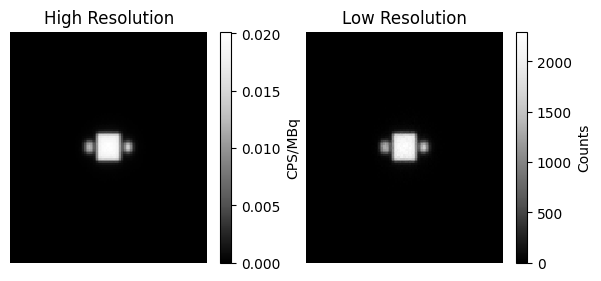

In [6]:
idx = 0
plt.subplots(1,2,figsize=(7,3))
plt.subplot(121)
plt.pcolormesh(projections[0,idx].cpu().T, cmap='Greys_r')
plt.colorbar(label='CPS/MBq')
plt.axis('off')
plt.title('High Resolution')
plt.subplot(122)
plt.pcolormesh(projections_noise[0,idx].cpu().T, cmap='Greys_r')
plt.colorbar(label='Counts')
plt.axis('off')
plt.title('Low Resolution')
plt.show()

So why did we choose three energy windows?

* On a real scanner, the only data one has access to is the equivalent of the `_tot` files: its impossible to know whether the photon you're measuring has scattered in the phantom or not

* Thus we need to estimate the `_sca` files by only using `_tot` files

By averaging energy window slightly above and slightly below the photopeak window, we can estimate the scatter

$$\hat{s} = \left(\frac{g_{\text{above}}}{w_{\text{above}}} + \frac{g_{\text{below}}}{w_{\text{below}}} \right) \frac{w_{\text{peak}}}{2}$$

where $\hat{s}$ is the estimate for scatter, $g$ consists of primaries and scatters, and $w$ is the width of the energy window. This is known as the **triple energy window** (TEW) scatter estimate technique

In [7]:
s_true = simind.get_projections('test_sca_w1.h00')
g_above = simind.get_projections('test_tot_w3.h00')
g_below = simind.get_projections('test_tot_w2.h00')
w_above = w_below = 10
w_peak = 229.2 - 187.6

s_TEW = (g_above/w_above + g_below/w_below) * w_peak / 2

We do it explicitly above, but `pytomography` has functionality to automatically obtain the TEW estimate

In [8]:
s_TEW = simind.get_scatter_from_TEW(
    headerfile_lower='test_tot_w2.h00',
    headerfile_upper='test_tot_w3.h00',
    headerfile_peak='test_tot_w1.h00')

We can compare the scatter estimate to the true scatter:

In [9]:
print(s_TEW.sum().item())
print(s_true.sum().item())

143.1632843017578
134.05735778808594


Pretty close with regards to the amount of scatter estimated. Let's look at the scatter projections

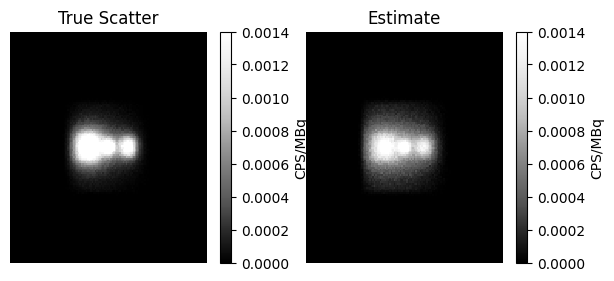

In [10]:
idx = 80
plt.subplots(1,2,figsize=(7,3))
plt.subplot(121)
plt.pcolormesh(s_true[0,idx].cpu().T, cmap='Greys_r', vmax=0.0014)
plt.colorbar(label='CPS/MBq')
plt.axis('off')
plt.title('True Scatter')
plt.subplot(122)
plt.pcolormesh(s_TEW[0,idx].cpu().T, cmap='Greys_r', vmax=0.0014)
plt.colorbar(label='CPS/MBq')
plt.axis('off')
plt.title('Estimate')
plt.show()

While it's not entirely matching, it provides good consistency in the region of the object. Let's make it representative of a real scan

In [11]:
s_TEW_noise = torch.poisson(s_TEW * activity * dT)

# Image Reconstruction

So we have 120 different projection images of this phantom. What do we do now to reconstruct

* That's what **PyTomography** is for

## Corrections

### 1. Information about the phantom

The first thing we need is information about how photons get attenuated in the phantom (linear attenuation coefficient $\mu$). This can be obtained from the .hct file, which gives $\mu$.

In [12]:
attenuation_map = simind.get_attenuation_map('test.hct')

In [13]:
attenuation_map.shape

torch.Size([1, 128, 128, 128])

Lets look at the central z-slice

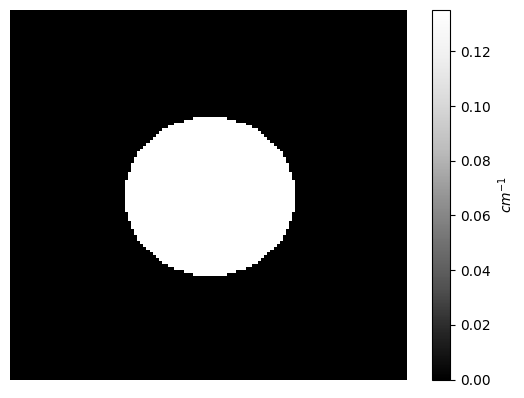

In [14]:
plt.pcolormesh(attenuation_map[0,:,:,64].cpu().T, cmap='Greys_r')
plt.colorbar(label='$cm^{-1}$')
plt.axis('off')
plt.show()

From this we will build an **attenuation transform** required for reconstruction in PyTomography. Inclusion of this transform will insure "attenuation correction" is applied during SPECT reconstruction

In [15]:
att_transform = SPECTAttenuationTransform(attenuation_map)

### 2. Image Blurring: Resolution Modeling

The lead collimators used don't block all photons from penetrating them; thus not all photons are exactly perpendicular to the detector when detected. This results in image blurring. We can correct for this by creating a PSF or "point spread function" transform, which will also be used in the reconstruction algorithm

In [16]:
psf_meta = simind.get_psfmeta_from_header('test_tot_w2.h00')
psf_transform = SPECTPSFTransform(psf_meta)

## System Modeling

Image reconstruction requires an accurate analytical model of the imaging system (i.e. it needs to approximate the simulation we did in SIMIND). This requires the so called "system matrix", which allows us to get projections $g$ from a source distribution $f$. 

* $f$ is referred to as an **object**
* $g$ is referred to as **projections**

We can get metadata such as voxel dimensions/spacing (object) and detector pixel dimensions/spacing (image) needed to build the system matrix

In [17]:
object_meta, proj_meta = simind.get_metadata('test_tot_w2.h00')

Now we can build our system matrix

In [19]:
system_matrix = SPECTSystemMatrix(
    obj2obj_transforms=[att_transform, psf_transform],
    proj2proj_transforms=[],
    object_meta=object_meta,
    proj_meta = proj_meta
)

## Reconstruction Algorithm

Now that we have a system matrix that can model our system, we are ready to reconstruct. We will use the algorithm used in clinical practice: OSEM

In [20]:
activity = 7400
dT = 15
projections = simind.get_projections('test_tot_w1.h00')
s_TEW = simind.get_scatter_from_TEW(
    headerfile_lower='test_tot_w2.h00',
    headerfile_upper='test_tot_w3.h00',
    headerfile_peak='test_tot_w1.h00')
projections = torch.poisson(projections*activity*dT)
s_TEW = torch.poisson(s_TEW*activity*dT)

In [21]:
osem = OSEM(
    projections=projections,
    system_matrix=system_matrix,
    scatter=s_TEW
)

OSEM is an iterative algorithm; we will reconstruct for 10 iterations.
* Note: if you do not have a GPU, or have PyTorch installed via a CPU installation, this may take a while to run

In [22]:
source_prediction = osem(n_iters=10, n_subsets=8)

In [23]:
source_prediction.shape

torch.Size([1, 128, 128, 128])

Let's convert it to a numpy array for plotting:

In [24]:
source_prediction = source_prediction[0].cpu().numpy()

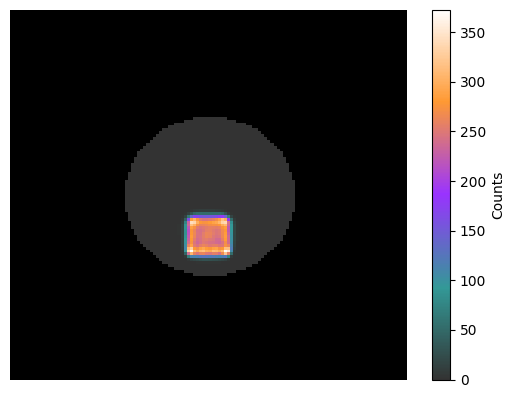

In [25]:
plt.pcolormesh(attenuation_map[0,:,:,70].cpu().T, cmap='Greys_r')
plt.pcolormesh(source_prediction[:,:,70].T, cmap=custom_cmap, alpha=0.8)
plt.colorbar(label='Counts')
plt.axis('off')
plt.show()

Note that the unit for radioactivity is still in counts! Ultimately, we want it in MBq, or more ideally, MBq/mL (density is independent of voxel size).

In order to adjust for these units, it is standard to do a scan of a very small source of known radioactivity, and take the ratio of the total number of counts to the total activity as a calibration factor.

* `simind jaszak point_calib/fi:lu177/cc:si-me/29:1/15:5/fa:11/fa:15/fa:14`


* 29:1 to set number of projections to 1
* 15:5 to set source type to point source
* fa:11 to ignore phantom (assumes no attenuation)
* fa:15 to not save phantom map
* fa:14 to not save header files (not needed here)

We can then open up the `point_calib.res` file and look for the CPS/MBq factor in the primary energy window

In [26]:
CPS_per_MBq = 0.106E+02

We need to convert this to units of MBq/count though. For this, we divide by the `CPS_per_MBq` and time per projection. If we **further** want units of MBq/mL (ideal), then we also need to divide by the voxel size

In [27]:
np.prod(object_meta.dr)

0.06400000000000002

In [28]:
calibration_factor = 1 / CPS_per_MBq / dT / np.prod(object_meta.dr)
source_prediction_MBqpmL = source_prediction * calibration_factor

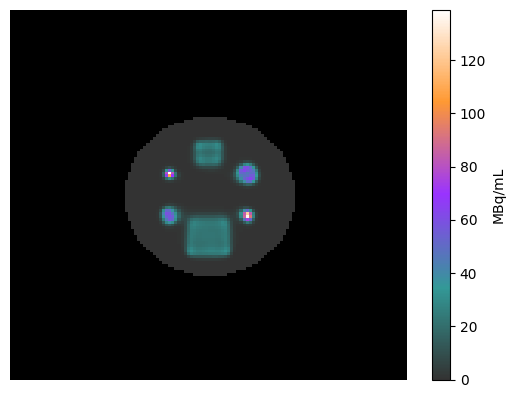

In [29]:
plt.pcolormesh(attenuation_map[0,:,:,64].cpu().T, cmap='Greys_r')
plt.pcolormesh(source_prediction_MBqpmL[:,:,64].T, cmap=custom_cmap, alpha=0.8)
plt.colorbar(label='MBq/mL')
plt.axis('off')
plt.show()

We can then check the total activity as a consistency check

In [30]:
print(activity)
print(source_prediction_MBqpmL.sum() * np.prod(object_meta.dr))

7400
7780.713000000002


Pretty Close! Note that it will not be exact due to imperfections in estimating scatter in the TEW technique.

# For Fun

Let's make a 3D animation like we did last time

In [28]:
attenuation_map_numpy = attenuation_map[0].cpu().numpy()

In [29]:
attenuation_map_numpy.shape

(128, 128, 128)

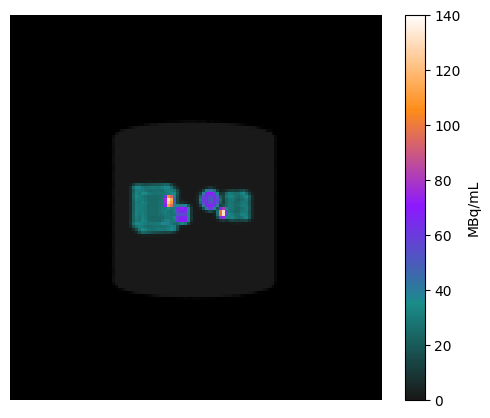

In [30]:
fig, ax = plt.subplots(figsize=(6,5))

def update_plot(frame):
    plt.clf()
    # Plot phantom
    im = rotate(attenuation_map_numpy, 5*frame, axes=(0,1), reshape=False)
    im = rotate(im, 10, axes=(0,2), reshape=False).max(axis=0) # rotate camera angle up a little
    C1 = plt.pcolormesh(im.T, cmap='Greys_r', vmin=0, vmax=0.15)
    # Plot predicted source distribution
    im = rotate(source_prediction_MBqpmL, 5*frame, axes=(0,1), reshape=False)
    im = rotate(im, 10, axes=(0,2), reshape=False).max(axis=0) # rotate camera angle up a little
    C2 = plt.pcolormesh(im.T, cmap=custom_cmap, vmin=0, vmax=140, alpha=0.9)
    plt.axis('off')
    plt.colorbar(label='MBq/mL')
    return C1, C2

anim = FuncAnimation(fig, update_plot, interval=30, blit=True, frames=71)
anim.save(f'prediction.gif', writer='pillow', fps=30, dpi=200)